# Importing training Data
TODO: dealing with test data loading

In [1]:
import numpy as np
from glob import glob
import omegaconf
from utils.data import DataLoader
import matplotlib.pyplot as plt



In [2]:
conf = omegaconf.OmegaConf.load('configs/baseConfig.yaml')

In [3]:

trainLoader = DataLoader(**conf.LoaderParams)
batch = next(iter(trainLoader))
print(batch.shape)

(256, 200, 45, 3)


In [5]:
normalize = lambda x: (x - x.min()) / (x.max() - x.min())
xnorm = normalize(batch)

In [7]:
xsample = xnorm[0,:,0]
ysample = xnorm[0,:,1]

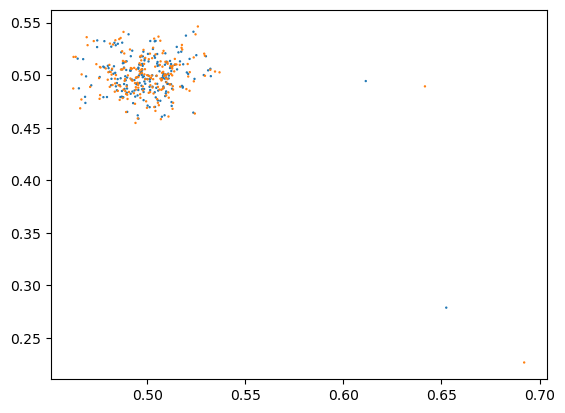

In [10]:
plt.scatter(xsample[:,0], xsample[:,1],s=xsample[:,2])
plt.scatter(ysample[:,0], ysample[:,1],s=ysample[:,2])
plt.show()

In [8]:
trainLoader.wpts

['_25', '_50', '_130', '_125', '_100', '_150', '_70']

In [37]:
conf.ValLoaderParams.ParticleNumber = conf.LoaderParams.ParticleNumber
conf.ValLoaderParams

{'numWPTS': 1000, 'batch_size': 256, 'excludes': ['200'], 'mode': 'val', 'ParticleNumber': [200]}

In [5]:
valLoader = DataLoader(**conf.ValLoaderParams)

In [4]:
conf.LoaderParams

{'numWPTS': 10000, 'batch_size': 32, 'excludes': ['test', '10'], 'ParticleNumber': [200]}

In [14]:
y = batch[:,:,0]
xl = batch[:,:,1]


In [21]:
sampley = y[0]
sampleX = xl[0]


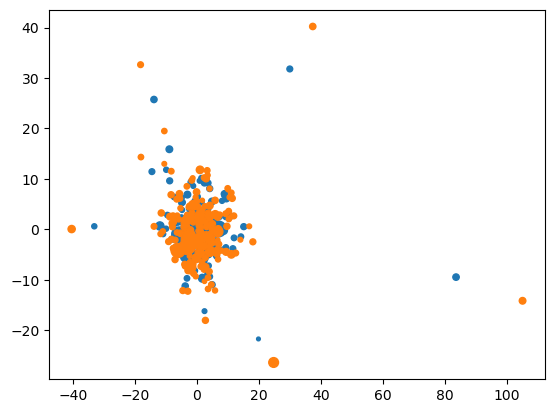

In [25]:
plt.scatter(sampley[:,0], sampley[:,1],s=sampley[:,2]*1000)
plt.scatter(sampleX[:,0], sampleX[:,1],s=sampleX[:,2]*1000)
plt.show()

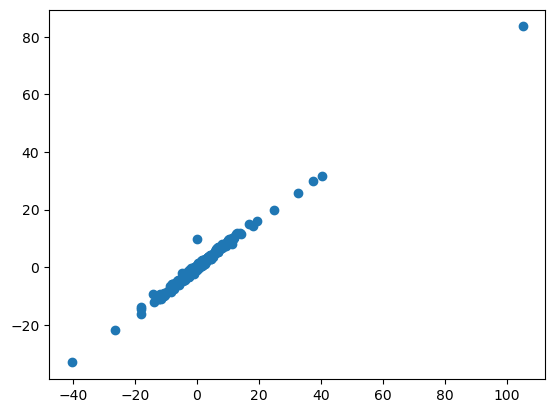

In [ ]:
plt.scatter(y[0])

# Model testings

In [6]:
from utils.model import PosPredictor

/home/bdudas/anaconda3/envs/pct/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

/home/bdudas/anaconda3/envs/pct/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=1)

In [8]:
model = PosPredictor(**conf.ModelParams)

In [9]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
model.compile(optimizer=optim.Adam,loss=nn.MSELoss,device = device)

cuda


In [18]:
x = batch
sampleX = torch.from_numpy(x[:,:,0])
sampleX.shape

torch.Size([256, 200, 3])

In [ ]:
nn.BatchNorm1d()

In [24]:
bnorm = nn.BatchNorm1d(200)
bnorm(sampleX).shape

torch.Size([256, 200, 3])

In [10]:
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter()
logdir = writer.log_dir
with open(f'{logdir}/config.yaml', 'w') as f:
    omegaconf.OmegaConf.save(conf, f)
model.add_logger(writer)

2025-02-23 14:54:56.600670: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [49]:
B = 2
P = 2
D = 3
sampleX = torch.randn((B,P,D))
sampley = torch.randn((B,P,D))

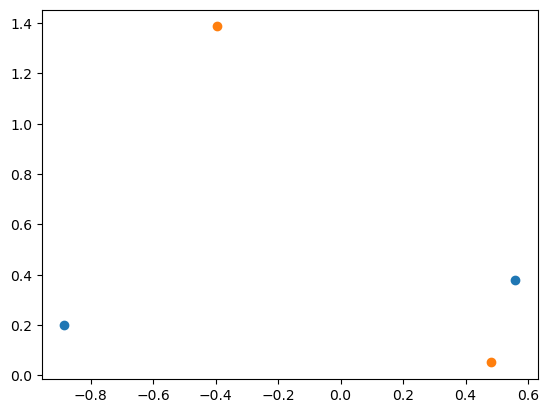

In [52]:
plt.scatter(sampleX[0,:,0], sampleX[0,:,1])
plt.scatter(sampley[0,:,0], sampley[0,:,1])

In [53]:
distMX = torch.cdist(torch.tensor(sampleX),torch.tensor(sampley))
res = SinkhornMatching(distMX,temp=0.59,n_iter=10)
agmx = torch.argmax(res,dim=1)

/tmp/ipykernel_243703/2201815442.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  distMX = torch.cdist(torch.tensor(sampleX),torch.tensor(sampley))


In [58]:
sampley[0]

tensor([[ 0.4817,  0.0515, -0.1204],
        [-0.3956,  1.3865, -1.9579]])

In [59]:
sampleX[0]

tensor([[-0.8842,  0.2020,  0.5201],
        [ 0.5590,  0.3790,  0.3833]])

In [54]:
agmx

tensor([[1, 0],
        [1, 0]])

In [4]:
x = torch.tensor([[[0.,0.],[1.,1.],[2.,2.]],[[0.,0.],[1.,1.],[2.,2.]]])
y = torch.tensor([[[0.,0.],[1.,1.],[2.,2.]],[[0.,0.],[2.,2.],[1.,1.]]])
print(x.shape,y.shape)



torch.Size([2, 3, 2]) torch.Size([2, 3, 2])


In [5]:
distMX = torch.cdist(x,y)


In [6]:
distMX.shape

torch.Size([2, 3, 3])

In [7]:
distMX

tensor([[[0.0000, 1.4142, 2.8284],
         [1.4142, 0.0000, 1.4142],
         [2.8284, 1.4142, 0.0000]],

        [[0.0000, 2.8284, 1.4142],
         [1.4142, 1.4142, 0.0000],
         [2.8284, 0.0000, 1.4142]]])

In [8]:
MostLikelyMatches = SinkhornMatching(distMX,temp=0.59,n_iter=10)


In [9]:
agmx = torch.argmax(MostLikelyMatches,dim=1)
agmx.shape

torch.Size([2, 3])

In [11]:
xmaxes = torch.argmax(MostLikelyMatches,dim=1)
ymaxes = torch.argmax(MostLikelyMatches,dim=2)
print(xmaxes.shape,ymaxes.shape)

torch.Size([2, 3]) torch.Size([2, 3])


In [12]:
xmaxes

tensor([[0, 1, 2],
        [0, 2, 1]])

In [13]:
ymaxes

tensor([[0, 1, 2],
        [0, 2, 1]])

In [16]:
mask = xmaxes == ymaxes
mask[0][0] = False
mask    

tensor([[False,  True,  True],
        [ True,  True,  True]])

In [22]:
y.shape

torch.Size([2, 3, 2])

In [23]:
mask.shape

torch.Size([2, 3])

In [10]:
agmx

tensor([[0, 1, 2],
        [0, 2, 1]])

In [30]:
mask[0].shape

torch.Size([3])

In [31]:
truepoints = y[0][mask[0]]
truepoints.shape, y[0].shape
comparepoint = x[0][agmx[0]][mask[0]]
comparepoint.shape, x[0].shape,truepoints.shape

(torch.Size([2, 2]), torch.Size([3, 2]), torch.Size([2, 2]))

In [33]:
y.shape

torch.Size([2, 3, 2])

In [36]:
torch.sum(mask== False).item()

1

In [38]:
numMatches = 0.
for b in range(y.shape[0]):
    truepoints = y[b][mask[b]]
    comparepoints = x[b][agmx[b]][mask[b]]
    numMatches += torch.sum(comparepoints == truepoints)
numMatches = numMatches / (y.shape[0] * y.shape[1]*y.shape[2] - torch.sum(mask== False).item())

In [39]:
numMatches

tensor(0.9091)

In [ ]:
batch = next(iter(trainLoader))


In [32]:
x = batch[:1,:20,1]
y = batch[:1,:20,0]

In [33]:
TrueMatches = torch.arange(y.shape[0])

In [34]:
pidxs = np.random.permutation(y.shape[1])


In [35]:
y = y[:,pidxs]
y.shape

(1, 20, 3)

In [36]:
distMX = torch.cdist(torch.tensor(x),torch.tensor(y))

In [3]:
def SinkhornMatching(distMx,temp=0.59,n_iter=10):
    S = torch.softmax(-distMx/temp,dim=1)
    for i in range(n_iter):
        S /= torch.sum(S,dim=1,keepdim=True)
        S /= torch.sum(S,dim=2,keepdim=True)
    return S


In [38]:
res = SinkhornMatching(distMX,temp=0.59,n_iter=10)
agmx = torch.argmax(res,dim=1)
agmx.shape

torch.Size([1, 20])

In [39]:
y = torch.tensor(y)
agmx.shape

torch.Size([1, 20])

In [40]:
matches = 0
for b in range(y.shape[0]):
    matches += torch.sum(y[b][agmx[b]] == y[b])
matches.item()

0

In [41]:
TrueMatches = torch.arange(y.shape[0])


In [42]:
comparison = (agmx == TrueMatches.unsqueeze(1))*1.
comparison.shape

torch.Size([1, 20])

In [46]:
comparison.sum()/comparison.numel()

tensor(0.0500)

In [44]:
comparison.mean()

tensor(0.0500)

In [122]:
len(trainLoader.allPaths)//conf.LoaderParams.batch_size

273